In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import h5py
import imageio
import matplotlib
import gc
import sys
import io
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from scipy.optimize import curve_fit
import scipy.integrate


# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(rf'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM
plt.rcParams.update({'font.size': 14})  

tidy3dAPI = os.environ["API_TIDY3D_KEY"]
plt.rc('font', family='Arial')


In [ ]:
file = rf"H:\phd stuff\tidy3d\output\LSU Data\transmission_different_permmitivities_thickness.h5"
with h5py.File(file, 'r') as h5f:
    data = {
            'transmission_right':h5f["transmission_right"][:],
            'name':h5f["name"],
            'nu(a/lambda)':h5f["nu(a/lambda)"][:],
            "raw_freqs(Hz)":h5f["raw_freqs(Hz)"][:],
            "sizes":h5f["sizes"][:],
            "cell_size":h5f["cell_size"],
            "a":h5f["a"],
            "eps":h5f["eps"][:]
                        
            }

In [ ]:
# dir_plot = Path(rf"H:\phd stuff\tidy3d\output\LSU Data\ThicknessEpsVariations")
# dir_plot.mkdir(parents=True,exist_ok=True)
# for i,eps in enumerate(data["eps"]):
#     plt.figure(figsize=(20, 10))
#     for j,size in enumerate(data["sizes"]):
#         plt.plot(data["nu(a/lambda)"],data["transmission_right"][i,j,:],"o",label=rf"L_{size*14.3/3.4 : .4f}a")
#         plt.legend()
#         plt.yscale("log")

#     plt.xlabel(rf"$\nu(a/\lambda)$")
#     plt.ylabel("Transmission")
#     plt.grid(True,which="both")
#     plt.savefig(rf"{dir_plot}\eps_{eps}.pdf")    
#     plt.close()

In [148]:
convoluted_transmission = np.ones(np.shape(data["transmission_right"]))

import scipy.ndimage
for i,eps in enumerate(data["eps"]):
    for j,size in enumerate(data["sizes"]):
        plt.figure(figsize=(20, 10))
        sigma = 1.8  # Adjust for more/less smoothing
        smoothed_transmission = scipy.ndimage.gaussian_filter1d(data["transmission_right"][i,j,:], sigma)
        convoluted_transmission[i,j]=np.copy(smoothed_transmission)
        plt.plot(data["nu(a/lambda)"],data["transmission_right"][i,j,:],"o",label="Original")
        plt.plot(data["nu(a/lambda)"],smoothed_transmission,label="Convolution")
        plt.legend()
        plt.yscale("log")
        plt.xlabel(rf"$\nu(a/\lambda)$")
        plt.ylabel("Transmission")
        plt.grid(True,which="both")
        plt.title(rf"L_{size*14.3/3.4 : .4f}a")
        dir_plot = Path(rf"H:\phd stuff\tidy3d\output\LSU Data\Convolutions\n_rod_{np.sqrt(eps):.2f}")
        dir_plot.mkdir(parents=True,exist_ok=True)
        plt.savefig(rf"{dir_plot}\{rf"L_{size*14.3/3.4:.4f}a"}.pdf")
        plt.close()
       



In [149]:
min_transmission = np.min(convoluted_transmission,axis=2)
min_transmission_index = np.argmin(convoluted_transmission, axis=2)
min_transmission_raw = np.min(data["transmission_right"],axis=2)
min_transmission_index_raw_data = np.argmin(data["transmission_right"], axis=2)

In [150]:
for i in range(min_transmission_index.shape[0]):  # Loop over the first axis (10)
    for j in range(min_transmission_index.shape[1]):  # Loop over second axis (16)
        item = min_transmission_index[i, j]  # Extract scalar index
        item_2 = min_transmission_index_raw_data[i, j]  # Extract scalar index
        plt.scatter(data["sizes"][j], data["transmission_right"][i, j, item], color="b")  
        plt.scatter(data["sizes"][j], data["transmission_right"][i, j, item_2], color="r")  
        plt.title(rf"eps={data['eps'][i]}")
        plt.xlabel("L")
        plt.ylabel("Transmission")
        plt.yscale("log")
        
    plt.close()  


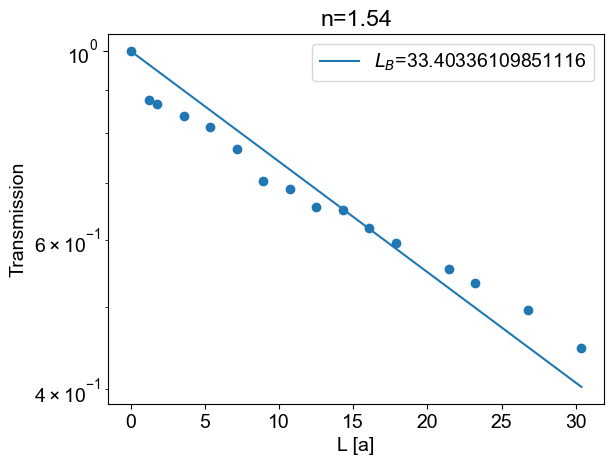

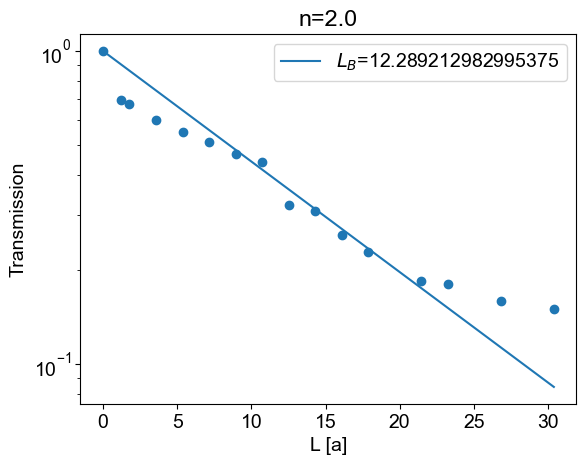

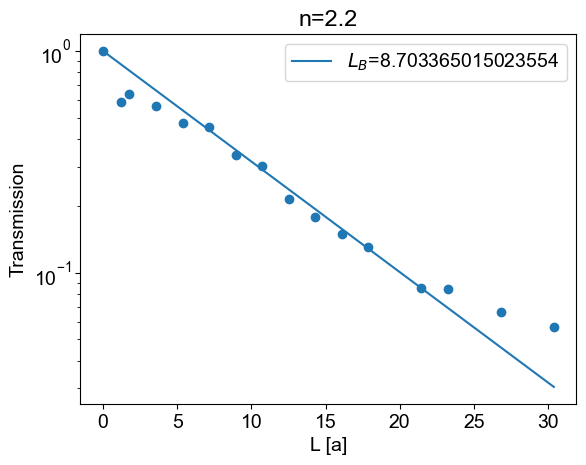

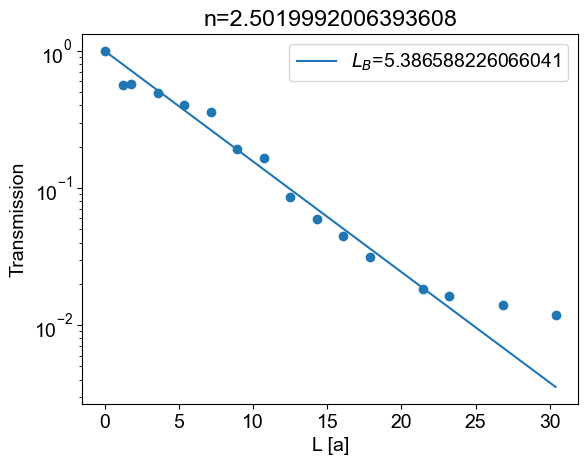

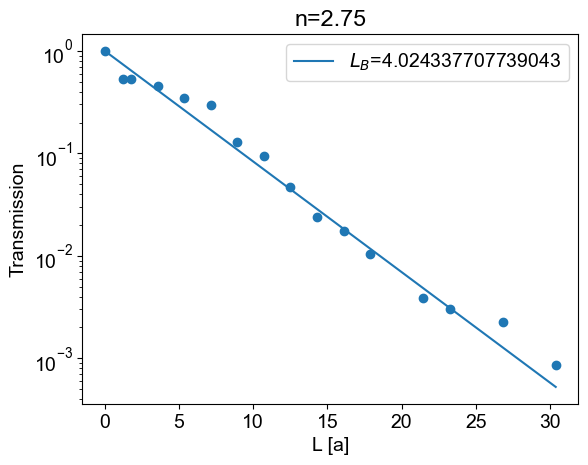

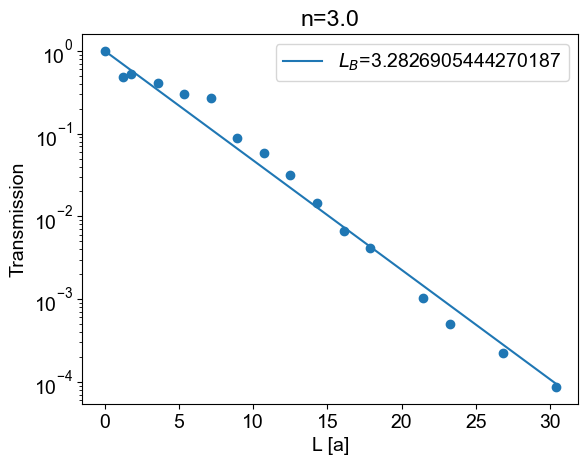

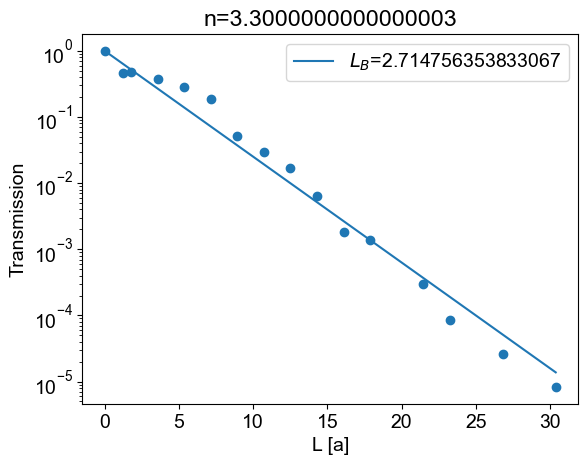

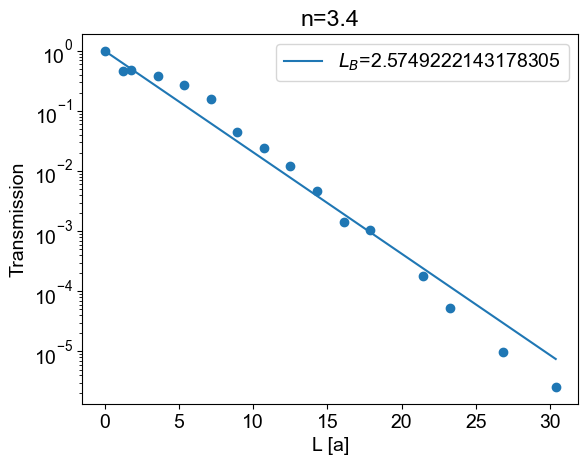

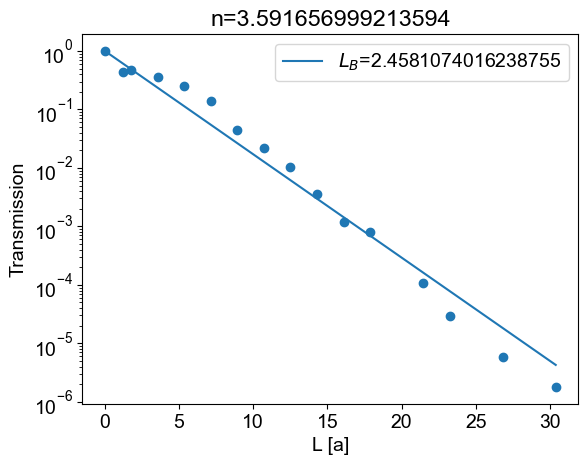

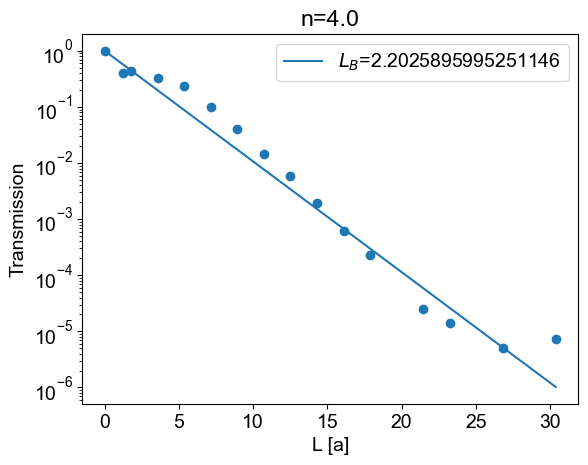

In [151]:
def fit_line(x,m):
    return m*x 

initial_guess = [-1]

sizes = data["sizes"]*14.3/0.8
LB_values = []
for i,item in enumerate(min_transmission):
    popt, _ = curve_fit(fit_line, sizes[2:-2], np.log(item[2:-2]), p0=initial_guess)
    plt.scatter(sizes,item)
    plt.plot(sizes,np.exp(fit_line(sizes,popt[0])), label=rf"$L_B$={(-1/popt[0])}")
    LB_values.append(-1/popt[0])
    plt.title(rf"n={np.sqrt(data["eps"][i])}")
    plt.xlabel("L [a]")
    plt.ylabel("Transmission")
    plt.yscale("log")
    plt.legend()
    plt.show()

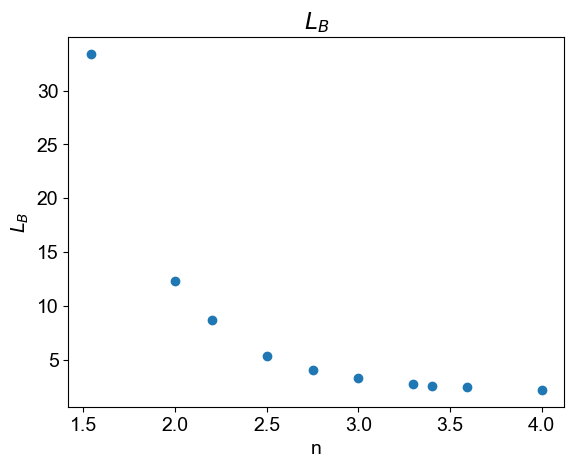

In [152]:
plt.scatter(np.sqrt(data["eps"]),LB_values)
plt.title(rf"$L_B$")
plt.xlabel("n")
plt.ylabel("$L_B$")
plt.show()

In [153]:
gap_index = min_transmission_index[:,np.where(data["sizes"]==1)[0]].squeeze()
np.shape(gap_index)

(10,)

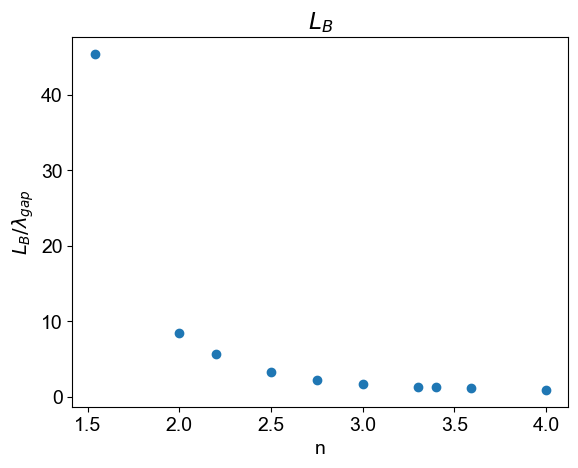

In [154]:
plt.scatter(np.sqrt(data["eps"]),LB_values*(data["nu(a/lambda)"][gap_index]))
plt.title(rf"$L_B$")
plt.xlabel(rf"n")
plt.ylabel(r"$L_B/\lambda_{gap}$")
plt.show()

In [168]:
data_txt = np.column_stack((np.sqrt(data["eps"]),LB_values))

In [169]:
np.savetxt(rf"H:\phd stuff\tidy3d\output\LSU Data\txtData\L_B_Analysis.txt", 
           data_txt, fmt="%.18f", delimiter=" ", header="index_n L_B", comments="")
